In [1]:
!nvidia-smi

Mon May 24 09:39:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   47C    P0    74W / 149W |  11034MiB / 11441MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [3]:
# Hier kann das Spiel übergeben werden
game = "Pong-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [6]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [7]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [8]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [9]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [10]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

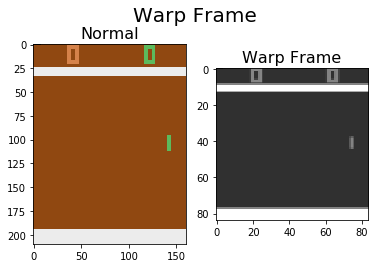

In [11]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [12]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

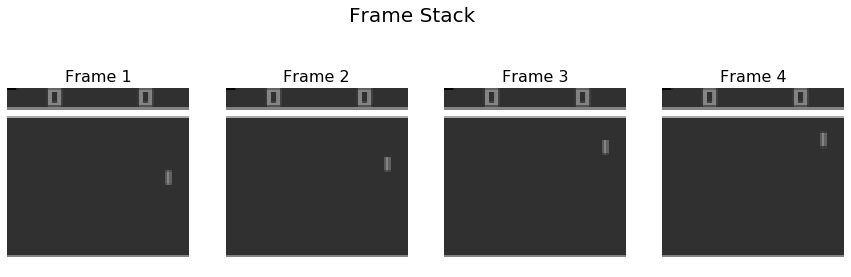

In [13]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [14]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)


""" saving the properties for csv """
MODE = "NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/Pong-v0/NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife/


# **Convolutional Neural Network**

In [15]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "categorical_crossentropy"
OPTIMIZER = RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    x = Dense(env.action_space.n, kernel_initializer='he_uniform')(x)
    net_output = Activation("softmax")(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Agent Network
CNN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

## Aktion wählen

In [16]:
def get_action(state):
    policy = CNN.predict(state)[0]
    action = np.random.choice(env.action_space.n, p=policy)
    return action

## Discount Rewards

In [17]:
def discount_rewards(REWARDS):
    gamma = 0.99
    running_add = 0
    discounted_r = np.zeros_like(REWARDS)
    for i in reversed(range(0, len(REWARDS))):
        if REWARDS[i] != 0:
            running_add = 0
        running_add = running_add * gamma + REWARDS[i]
        discounted_r[i] = running_add
        
        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r)

    return discounted_r

In [18]:
def append_sample(state, action, reward):
    STATES.append(state)
    action_onehot = np.zeros([env.action_space.n])
    action_onehot[action] = 1
    ACTIONS.append(action_onehot)
    REWARDS.append(reward)

## Update Policy

In [19]:
def update_policy(STATES, ACTIONS, REWARDS):
    states = np.vstack(STATES)
    actions = np.vstack(ACTIONS)
    
    # discount rewards
    discounted_r = discount_rewards(REWARDS)
    
    # training
    CNN.fit(states, actions, sample_weight=discounted_r, epochs=1, verbose=0)
    
    # leeren des Episoden Buffers
    STATES, ACTIONS, REWARDS = [], [], []

# Trainings des Agenten

In [20]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

-21.0

In [21]:
EPISODES = 10_000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
STATES, ACTIONS, REWARDS = [], [], []

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # Transition zwischenspeichern
        append_sample(state, action, reward)
        
        # State aktualisieren
        state = next_state

        if done:
            update_policy(STATES, ACTIONS, REWARDS)
            
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward

                import os
                try:
                    os.makedirs(PATH)
                except FileExistsError:
                    # Pfad existiert bereits
                    pass
                CNN.save_weights(PATH +"Best.h5")

W0524 09:39:49.889804 139881494673216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: -21.0 	Mean: -21.0 	BestMean: -21.0
Episode: 2 	Reward: -20.0 	Mean: -20.5 	BestMean: -21.0
Episode: 3 	Reward: -20.0 	Mean: -20.33 	BestMean: -20.5
Episode: 4 	Reward: -21.0 	Mean: -20.5 	BestMean: -20.333333333333332
Episode: 5 	Reward: -21.0 	Mean: -20.6 	BestMean: -20.333333333333332
Episode: 6 	Reward: -20.0 	Mean: -20.5 	BestMean: -20.333333333333332
Episode: 7 	Reward: -21.0 	Mean: -20.57 	BestMean: -20.333333333333332
Episode: 8 	Reward: -20.0 	Mean: -20.5 	BestMean: -20.333333333333332
Episode: 9 	Reward: -21.0 	Mean: -20.56 	BestMean: -20.333333333333332
Episode: 10 	Reward: -21.0 	Mean: -20.6 	BestMean: -20.333333333333332
Episode: 11 	Reward: -21.0 	Mean: -20.6 	BestMean: -20.333333333333332
Episode: 12 	Reward: -21.0 	Mean: -20.7 	BestMean: -20.333333333333332
Episode: 13 	Reward: -21.0 	Mean: -20.8 	BestMean: -20.333333333333332
Episode: 14 	Reward: -21.0 	Mean: -20.8 	BestMean: -20.333333333333332
Episode: 15 	Reward: -21.0 	Mean: -20.8 	BestMean: -20

ResourceExhaustedError:  OOM when allocating tensor with shape[7744,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node RMSprop/RMSprop/update_6/Square (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_4183]

Function call stack:
distributed_function
